In [ ]:
%%bash
# Do not change or modify this cell
# Need to install pyspark
# if pyspark is already installed, will print a message indicating pyspark already installed
pip install pyspark &> /dev/null

In [ ]:
# Load the packages needed for this part
# create spark and sparkcontext objects
from pyspark.sql import SparkSession
import numpy as np

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

from pyspark.ml import feature, regression, Pipeline, pipeline
from pyspark.sql import types, Row, functions as fn
from pyspark import sql
import pandas as pd
import matplotlib.pyplot as plt
import pyspark.sql.functions as F
from pyspark.sql.functions import year, month, dayofmonth
from pyspark.sql.functions import to_date

from pyspark.sql import functions as fn
from pyspark.sql.functions import isnan, when, count, col

from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import DecisionTreeClassifier


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Read data
df = spark.read.json("/content/drive/MyDrive/transactions.txt")

In [ ]:
df=df.toPandas()

In [ ]:
df.show()

+-------------+---------------+----------+--------------+-------+---------------+-----------+-----------+--------------+--------------+----------+-----------------------+----------+----------+------------------------+-------+--------------------+------------+-------------------+--------------------+-------------+-----------+----------------+------------+-------------+----------------+-----------------+-------------------+--------------------+
|accountNumber|accountOpenDate|acqCountry|availableMoney|cardCVV|cardLast4Digits|cardPresent|creditLimit|currentBalance|currentExpDate|customerId|dateOfLastAddressChange|echoBuffer|enteredCVV|expirationDateKeyInMatch|isFraud|merchantCategoryCode|merchantCity|merchantCountryCode|        merchantName|merchantState|merchantZip|posConditionCode|posEntryMode|posOnPremises|recurringAuthInd|transactionAmount|transactionDateTime|     transactionType|
+-------------+---------------+----------+--------------+-------+---------------+-----------+-----------+-

In [ ]:
# Understand datatype of each columns
df.dtypes

[('accountNumber', 'string'),
 ('accountOpenDate', 'string'),
 ('acqCountry', 'string'),
 ('availableMoney', 'double'),
 ('cardCVV', 'string'),
 ('cardLast4Digits', 'string'),
 ('cardPresent', 'boolean'),
 ('creditLimit', 'double'),
 ('currentBalance', 'double'),
 ('currentExpDate', 'string'),
 ('customerId', 'string'),
 ('dateOfLastAddressChange', 'string'),
 ('echoBuffer', 'string'),
 ('enteredCVV', 'string'),
 ('expirationDateKeyInMatch', 'boolean'),
 ('isFraud', 'boolean'),
 ('merchantCategoryCode', 'string'),
 ('merchantCity', 'string'),
 ('merchantCountryCode', 'string'),
 ('merchantName', 'string'),
 ('merchantState', 'string'),
 ('merchantZip', 'string'),
 ('posConditionCode', 'string'),
 ('posEntryMode', 'string'),
 ('posOnPremises', 'string'),
 ('recurringAuthInd', 'string'),
 ('transactionAmount', 'double'),
 ('transactionDateTime', 'string'),
 ('transactionType', 'string')]

In [ ]:
from pyspark.sql.functions import col,when
replaceCols = df.columns
df2 = df.select([when(col(c)=="",None).otherwise(col(c)).alias(c) for c in replaceCols])

In [ ]:
# Removing rows where transactionType is Address_Verification
df2 = df2.filter(df2.transactionType != 'ADDRESS_VERIFICATION')

Exploratory Data Analysis

In [ ]:
#Summary Statistics
df_numeric = df2.select('creditLimit','currentBalance','transactionAmount')
df_numeric.describe().show()

+-------+------------------+-----------------+------------------+
|summary|       creditLimit|   currentBalance| transactionAmount|
+-------+------------------+-----------------+------------------+
|  count|            765496|           765496|            765496|
|   mean|10759.794303301389|4504.577983190006|140.57826265584745|
| stddev|11634.977120474114| 6455.04119391944| 147.9413198039696|
|    min|             250.0|              0.0|               0.0|
|    max|           50000.0|         47498.81|           2011.54|
+-------+------------------+-----------------+------------------+



In [ ]:
df2.groupBy("isFraud").count().show()

+-------+------+
|isFraud| count|
+-------+------+
|   true| 12287|
|  false|753209|
+-------+------+



In [ ]:
df2.groupBy("expirationDateKeyInMatch").count().show()

+------------------------+------+
|expirationDateKeyInMatch| count|
+------------------------+------+
|                    true|  1043|
|                   false|764453|
+------------------------+------+



In [ ]:
check = df2.groupBy("isFraud").count()

In [ ]:
check = check.toPandas()

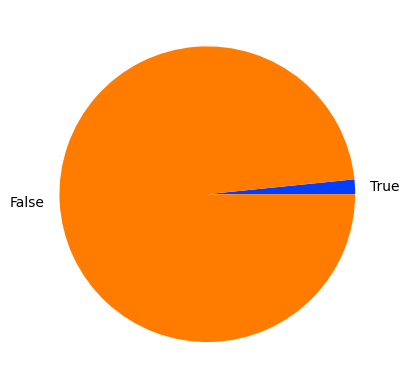

In [ ]:
import seaborn as sns
# define Seaborn color palette to use
palette_color = sns.color_palette('bright')

# plotting data on chart
plt.pie(check['count'], labels=check['isFraud'], colors=palette_color)

# displaying chart
plt.show()

In [ ]:
from pyspark.sql.functions import desc
df2.groupBy("merchantName").count().sort(desc("count")).show()

+--------------------+-----+
|        merchantName|count|
+--------------------+-----+
|                Uber|24862|
|                Lyft|24803|
|         staples.com|16510|
|         oldnavy.com|16494|
|         alibaba.com|16437|
|           apple.com|16399|
|         walmart.com|16384|
|            ebay.com|16375|
|       cheapfast.com|16348|
|          amazon.com|16329|
|          target.com|16320|
|           sears.com|16284|
|        discount.com|16281|
|             gap.com|16212|
|Fresh Online Serv...| 8142|
|Blue Mountain eCards| 8102|
|       Fresh Flowers| 8084|
|     Next Day eCards| 8045|
|Next Day Online S...| 8032|
|        Fresh eCards| 8021|
+--------------------+-----+
only showing top 20 rows



In [ ]:
df2.groupBy("merchantCategoryCode").count().sort(desc("count")).show()

+--------------------+------+
|merchantCategoryCode| count|
+--------------------+------+
|       online_retail|196373|
|            fastfood|108958|
|       entertainment| 77817|
|                food| 73304|
|        online_gifts| 64301|
|           rideshare| 49665|
|              hotels| 33155|
|                fuel| 23910|
|       subscriptions| 22228|
|                auto| 21024|
|              health| 18530|
|       personal care| 18406|
|          mobileapps| 14990|
|             airline| 14962|
|online_subscriptions| 11067|
|           furniture|  7215|
|       food_delivery|  6000|
|                 gym|  2209|
|         cable/phone|  1382|
+--------------------+------+



In [ ]:
df2.filter(df.transactionAmount == 0).count()

2056

In [ ]:
df2 = df2.filter(df2.transactionAmount != 0)

Visualization


<Axes: >

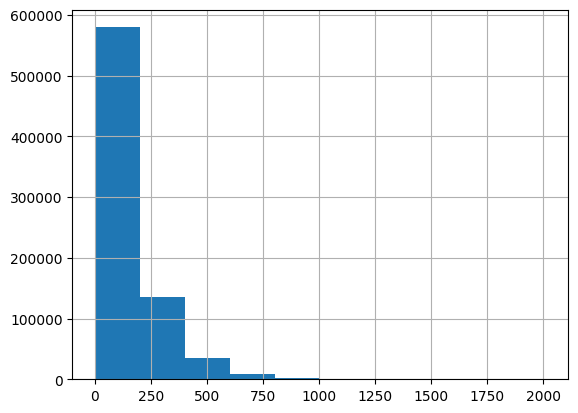

In [ ]:
# right skewed
viz_df = df2.toPandas()
viz_df.transactionAmount.hist()

<Axes: >

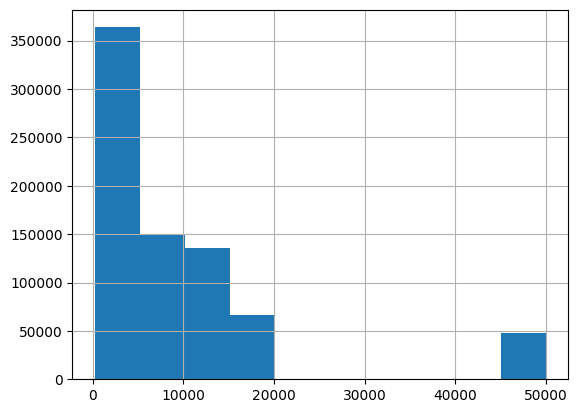

In [ ]:
viz_df.creditLimit.hist()

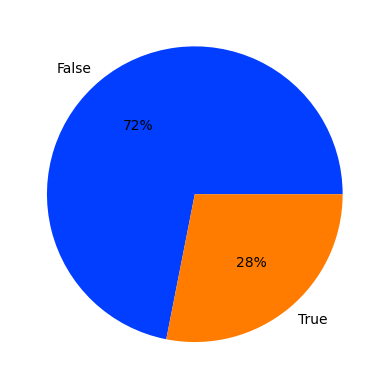

In [ ]:
import seaborn as sns
palette_color = sns.color_palette('bright')
plt.pie(viz_df[viz_df['isFraud']==True]['cardPresent'].value_counts(), labels=['False','True'], colors=palette_color, autopct='%.0f%%')
plt.show()

Text(0, 0.5, 'Merchant Name')

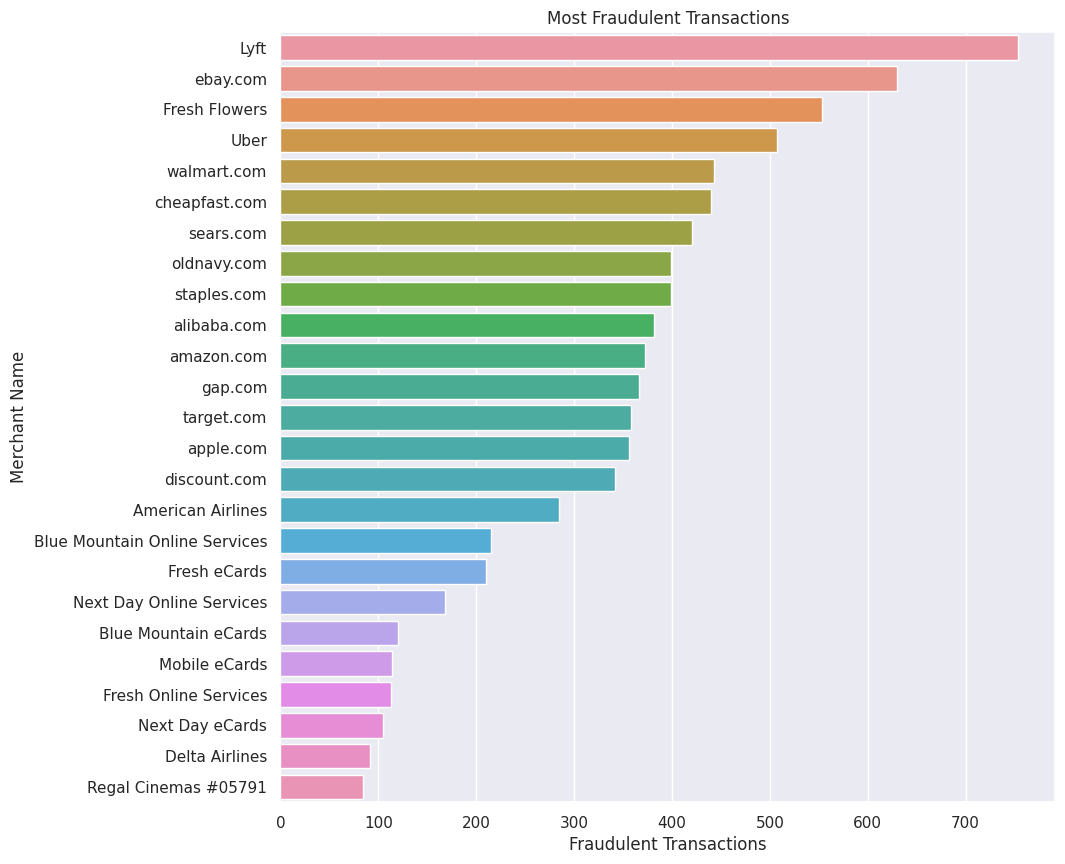

In [ ]:
fraud_df = viz_df[viz_df['isFraud'] == True]
sns.set(rc={'figure.figsize':(10,10)})

top25= fraud_df['merchantName'].value_counts().head(25)
sns.barplot(y=list(range(25)), x=top25.values, orient='h')

plt.title('Most Fraudulent Transactions')
plt.xlabel('Fraudulent Transactions')
plt.yticks(ticks=list(range(25)), labels=top25.index.tolist())
plt.ylabel('Merchant Name')

Text(0, 0.5, 'Customer Account')

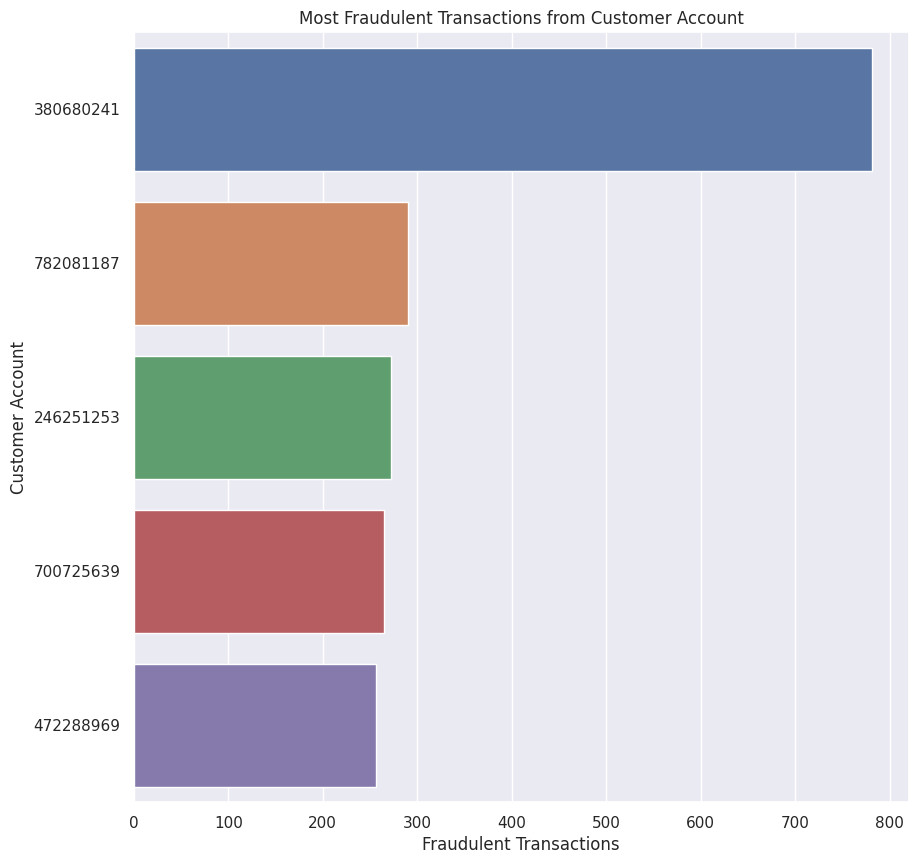

In [ ]:
top25= fraud_df['customerId'].value_counts().head(5)
sns.barplot(y=list(range(5)), x=top25.values, orient='h')
plt.title('Most Fraudulent Transactions from Customer Account')
plt.xlabel('Fraudulent Transactions')
plt.yticks(ticks=list(range(5)), labels=top25.index.tolist())
plt.ylabel('Customer Account')

In [ ]:
viz_df.transactionType.value_counts()

PURCHASE    743709
REVERSAL     19731
Name: transactionType, dtype: int64

Text(0, 0.5, 'Count')

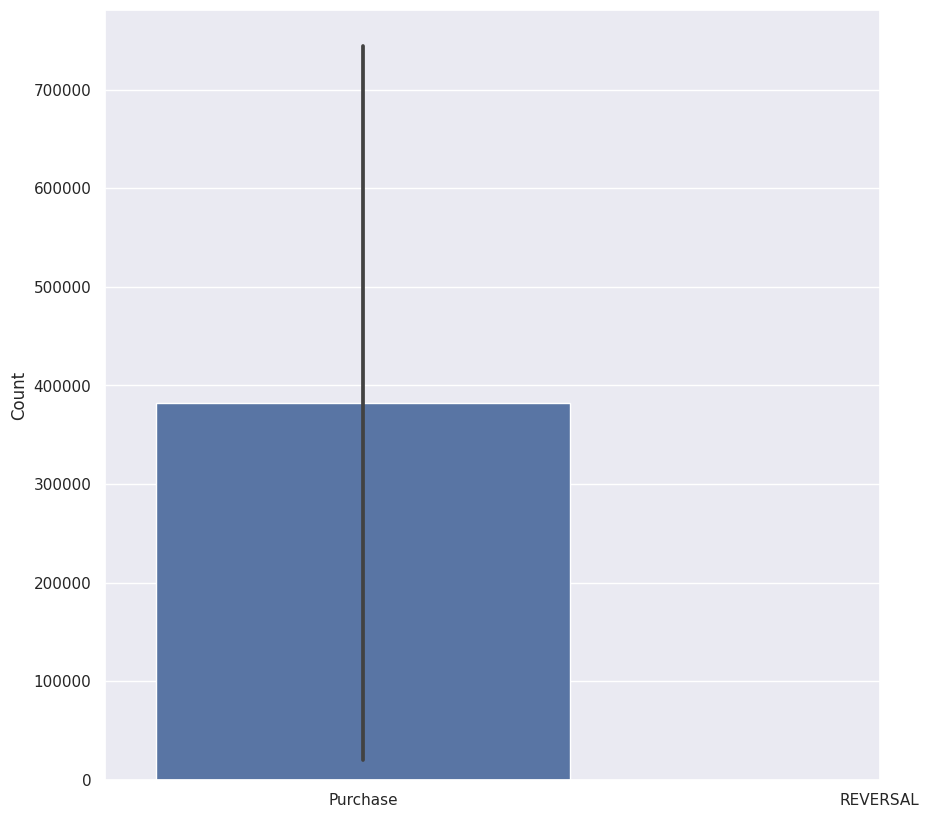

In [ ]:
sns.barplot(y=viz_df.transactionType.value_counts())
plt.xticks(ticks=[0,1], labels=['Purchase', 'REVERSAL'])
plt.ylabel('Count')

In [ ]:
rev_tran = df2.filter(df2.transactionType == 'REVERSAL')

In [ ]:
from pyspark.sql.functions import sum

In [ ]:
rev_tran.select(sum(rev_tran.transactionAmount)).show()


+----------------------+
|sum(transactionAmount)|
+----------------------+
|    2821792.5000000033|
+----------------------+



In [ ]:
df = df.withColumn("transactionDate_conv", to_date(df.transactionDateTime))

In [ ]:
from pyspark.sql.functions import when
df = df.withColumn(
    "MatchCVV", \
   when((df.enteredCVV == df.cardCVV), 1)\
   .otherwise(0)
  )

In [ ]:
df_select = df.select('creditLimit','transactionAmount','availableMoney','MatchCVV','posEntryMode','merchantCategoryCode',\
    month("transactionDate_conv").alias('month'), dayofmonth("transactionDate_conv").alias('day'),\
  'cardPresent','isFraud', 'transactionType','expirationDateKeyInMatch')

In [ ]:
df_select.show(20)

+-----------+-----------------+--------------+--------+------------+--------------------+-----+---+-----------+-------+--------------------+------------------------+
|creditLimit|transactionAmount|availableMoney|MatchCVV|posEntryMode|merchantCategoryCode|month|day|cardPresent|isFraud|     transactionType|expirationDateKeyInMatch|
+-----------+-----------------+--------------+--------+------------+--------------------+-----+---+-----------+-------+--------------------+------------------------+
|     5000.0|            98.55|        5000.0|       1|          02|           rideshare|    8| 13|      false|  false|            PURCHASE|                   false|
|     5000.0|            74.51|        5000.0|       1|          09|       entertainment|   10| 11|       true|  false|            PURCHASE|                   false|
|     5000.0|             7.47|        5000.0|       1|          09|          mobileapps|   11|  8|      false|  false|            PURCHASE|                   false|
|   

In [ ]:
from pyspark.ml.feature import OneHotEncoder

In [ ]:
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol="transactionType", outputCol="transactionType_encode").fit(df_select)
indexed_df = indexer.transform(df_select)
indexed_df.show(5)

+-----------+-----------------+--------------+--------+------------+--------------------+-----+---+-----------+-------+---------------+------------------------+----------------------+
|creditLimit|transactionAmount|availableMoney|MatchCVV|posEntryMode|merchantCategoryCode|month|day|cardPresent|isFraud|transactionType|expirationDateKeyInMatch|transactionType_encode|
+-----------+-----------------+--------------+--------+------------+--------------------+-----+---+-----------+-------+---------------+------------------------+----------------------+
|     5000.0|            98.55|        5000.0|       1|          02|           rideshare|    8| 13|      false|  false|       PURCHASE|                   false|                   0.0|
|     5000.0|            74.51|        5000.0|       1|          09|       entertainment|   10| 11|       true|  false|       PURCHASE|                   false|                   0.0|
|     5000.0|             7.47|        5000.0|       1|          09|          mo

In [ ]:
# Drop NA
df_select = df_select.na.drop()

In [ ]:
indexed_df = indexed_df.withColumn("cardPresent_int",F.col("cardPresent").cast("integer")).withColumn("label",F.col("isFraud").cast("integer")).withColumn("expirationDateKeyInMatch_int",F.col("expirationDateKeyInMatch").cast("integer"))

In [ ]:
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol="merchantCategoryCode", outputCol="merchantCategoryCode_encode").fit(indexed_df)
indexed_df = indexer.transform(indexed_df)

In [ ]:
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol="posEntryMode", outputCol="posEntryMode_encode").fit(indexed_df)
indexed_df = indexer.transform(indexed_df)
indexed_df.show(5)

+-----------+-----------------+--------------+--------+------------+--------------------+-----+---+-----------+-------+---------------+------------------------+----------------------+---------------+-----+----------------------------+---------------------------+-------------------+
|creditLimit|transactionAmount|availableMoney|MatchCVV|posEntryMode|merchantCategoryCode|month|day|cardPresent|isFraud|transactionType|expirationDateKeyInMatch|transactionType_encode|cardPresent_int|label|expirationDateKeyInMatch_int|merchantCategoryCode_encode|posEntryMode_encode|
+-----------+-----------------+--------------+--------+------------+--------------------+-----+---+-----------+-------+---------------+------------------------+----------------------+---------------+-----+----------------------------+---------------------------+-------------------+
|     5000.0|            98.55|        5000.0|       1|          02|           rideshare|    8| 13|      false|  false|       PURCHASE|                

In [ ]:
indexed_df.dtypes

[('creditLimit', 'double'),
 ('transactionAmount', 'double'),
 ('availableMoney', 'double'),
 ('MatchCVV', 'int'),
 ('posEntryMode', 'string'),
 ('merchantCategoryCode', 'string'),
 ('month', 'int'),
 ('day', 'int'),
 ('cardPresent', 'boolean'),
 ('isFraud', 'boolean'),
 ('transactionType', 'string'),
 ('expirationDateKeyInMatch', 'boolean'),
 ('transactionType_encode', 'double'),
 ('cardPresent_int', 'int'),
 ('label', 'int'),
 ('expirationDateKeyInMatch_int', 'int'),
 ('merchantCategoryCode_encode', 'double'),
 ('posEntryMode_encode', 'double')]

In [ ]:
indexed_df_select = indexed_df.select('creditLimit','transactionAmount','availableMoney','MatchCVV',\
    'month', 'day','transactionType_encode','cardPresent_int','merchantCategoryCode_encode','posEntryMode_encode','label','expirationDateKeyInMatch_int')

In [ ]:
indexed_df_select.show(5)

+-----------+-----------------+--------------+--------+-----+---+----------------------+---------------+---------------------------+-------------------+-----+----------------------------+
|creditLimit|transactionAmount|availableMoney|MatchCVV|month|day|transactionType_encode|cardPresent_int|merchantCategoryCode_encode|posEntryMode_encode|label|expirationDateKeyInMatch_int|
+-----------+-----------------+--------------+--------+-----+---+----------------------+---------------+---------------------------+-------------------+-----+----------------------------+
|     5000.0|            98.55|        5000.0|       1|    8| 13|                   0.0|              0|                        5.0|                2.0|    0|                           0|
|     5000.0|            74.51|        5000.0|       1|   10| 11|                   0.0|              1|                        2.0|                1.0|    0|                           0|
|     5000.0|             7.47|        5000.0|       1|   11

In [ ]:
indexed_df_0 = indexed_df_select.filter(indexed_df_select.label == 0)
indexed_df_1 = indexed_df_select.filter(indexed_df_select.label == 1)

In [ ]:
indexed_df_1.count()

12417

In [ ]:
#Stratify Sampling Strategy

In [ ]:
(df_0_1, df_0_2) = indexed_df_0.randomSplit([0.8, 0.2], seed=42)

In [ ]:
(df_1_1, df_1_2) = indexed_df_1.randomSplit([0.8, 0.2], seed=42)

In [ ]:
trainingData = df_1_1.unionByName(df_0_1)

In [ ]:
testData = df_1_2.unionByName(df_0_2)

In [ ]:
(trainingData, testData) = indexed_df_select.randomSplit([0.7, 0.3], seed=42)

In [ ]:
va = VectorAssembler().setInputCols(indexed_df_select.columns[:9]).setOutputCol('features')

In [ ]:
rf = RandomForestClassifier(featuresCol='features', labelCol='label')

In [ ]:
trans_pipe = Pipeline(stages=[va,rf])
fitted_trans_pipe = trans_pipe.fit(trainingData)

In [ ]:
rf_pipeline = Pipeline(stages=[va, rf]).fit(trainingData)

In [ ]:
bce = BinaryClassificationEvaluator()

In [ ]:
bce.evaluate(fitted_trans_pipe.transform(testData), {bce.metricName: "areaUnderROC"})

0.6726297499533509

In [ ]:
bce.evaluate(fitted_trans_pipe.transform(testData), {bce.metricName: "areaUnderPR"})

0.03755700957143407

In [ ]:
major_df = indexed_df_select.filter(F.col("label") == 0)
minor_df = indexed_df_select.filter(F.col("label") == 1)
ratio = int(major_df.count()/minor_df.count())
print("ratio: {}".format(ratio))

ratio: 62


In [ ]:
from pyspark.sql.functions import col, explode, array, lit

In [ ]:
a = range(ratio)
# duplicate the minority rows
oversampled_df = minor_df.withColumn("dummy", explode(array([lit(x) for x in a]))).drop('dummy')
# combine both oversampled minority rows and previous majority rows
combined_df = major_df.unionAll(oversampled_df)
combined_df.show()

+-----------+-----------------+--------------+--------+-----+---+----------------------+---------------+---------------------------+-------------------+-----+----------------------------+
|creditLimit|transactionAmount|availableMoney|MatchCVV|month|day|transactionType_encode|cardPresent_int|merchantCategoryCode_encode|posEntryMode_encode|label|expirationDateKeyInMatch_int|
+-----------+-----------------+--------------+--------+-----+---+----------------------+---------------+---------------------------+-------------------+-----+----------------------------+
|     5000.0|            98.55|        5000.0|       1|    8| 13|                   0.0|              0|                        5.0|                2.0|    0|                           0|
|     5000.0|            74.51|        5000.0|       1|   10| 11|                   0.0|              1|                        2.0|                1.0|    0|                           0|
|     5000.0|             7.47|        5000.0|       1|   11

In [ ]:
indexed_df_0 = combined_df.filter(combined_df.label == 0)
indexed_df_1 = combined_df.filter(combined_df.label == 1)

In [ ]:
(df_0_1, df_0_2) = indexed_df_0.randomSplit([0.8, 0.2], seed=42)
(df_1_1, df_1_2) = indexed_df_1.randomSplit([0.8, 0.2], seed=42)
trainingData = df_1_1.unionByName(df_0_1)
testData = df_1_2.unionByName(df_0_2)

In [ ]:
indexed_df_select.columns[:10]

['creditLimit',
 'transactionAmount',
 'availableMoney',
 'MatchCVV',
 'month',
 'day',
 'transactionType_encode',
 'cardPresent_int',
 'merchantCategoryCode_encode',
 'posEntryMode_encode']

In [ ]:
(trainingData, testData) = combined_df.randomSplit([0.7, 0.3], seed=42)

In [ ]:
va = VectorAssembler().setInputCols(indexed_df_select.columns[:10]).setOutputCol('features')

In [ ]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression().setLabelCol('label').setFeaturesCol('features')
pipe1 = Pipeline(stages=[va,lr])
fitted_trans_pipe = pipe1.fit(trainingData)

In [ ]:
bce.evaluate(fitted_trans_pipe.transform(testData), {bce.metricName: "areaUnderROC"})


0.7066712237751657

In [ ]:
bce.evaluate(fitted_trans_pipe.transform(testData), {bce.metricName: "areaUnderPR"})

0.6926206842143466

In [ ]:
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")
pipe2 = Pipeline(stages=[va,dt])
fitted_trans_pipe = pipe2.fit(trainingData)


In [ ]:
bce.evaluate(fitted_trans_pipe.transform(testData), {bce.metricName: "areaUnderROC"})


0.6803555131315644

In [ ]:
bce.evaluate(fitted_trans_pipe.transform(testData), {bce.metricName: "areaUnderPR"})

0.6719329765456108

In [ ]:
rf = RandomForestClassifier(featuresCol='features', labelCol='label')

In [ ]:
rf_pipeline = Pipeline(stages=[va, rf]).fit(trainingData)

In [ ]:
bce.evaluate(rf_pipeline.transform(testData), {bce.metricName: "areaUnderROC"})

0.7456141231804724

In [ ]:
bce.evaluate(rf_pipeline.transform(testData), {bce.metricName: "areaUnderPR"})

0.7257916032336748

In [ ]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression().setLabelCol('label').setFeaturesCol('features')
pipe1 = Pipeline(stages=[va,lr])
fitted_trans_pipe = pipe1.fit(trainingData)
bce.evaluate(fitted_trans_pipe.transform(testData), {bce.metricName: "areaUnderROC"})
bce.evaluate(fitted_trans_pipe.transform(testData), {bce.metricName: "areaUnderPR"})

In [ ]:
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")
pipe1 = Pipeline(stages=[va,dt])
fitted_trans_pipe = pipe1.fit(trainingData)
bce.evaluate(fitted_trans_pipe.transform(testData), {bce.metricName: "areaUnderROC"})
bce.evaluate(fitted_trans_pipe.transform(testData), {bce.metricName: "areaUnderPR"})

In [ ]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics

# Scala version implements .roc() and .pr()
# Python: https://spark.apache.org/docs/latest/api/python/_modules/pyspark/mllib/common.html
# Scala: https://spark.apache.org/docs/latest/api/java/org/apache/spark/mllib/evaluation/BinaryClassificationMetrics.html
class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        points = []
        # Note this collect could be inefficient for large datasets
        # considering there may be one probability per datapoint (at most)
        # The Scala version takes a numBins parameter,
        # but it doesn't seem possible to pass this from Python to Java
        for row in rdd.collect():
            # Results are returned as type scala.Tuple2,
            # which doesn't appear to have a py4j mapping
            points += [(float(row._1()), float(row._2()))]
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)

In [ ]:
# your code here
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.linalg import Vectors
from pyspark.ml.tuning import CrossValidator,ParamGridBuilder

#lr = LogisticRegression().setLabelCol('spam').setFeaturesCol('tfidf')
params = ParamGridBuilder().addGrid(lr.elasticNetParam, [0.1, 0.2, 0.4]).addGrid(lr.regParam,[0.4,0.6]).build()
evaluator = BinaryClassificationEvaluator().setLabelCol("label")
cv2 = CrossValidator(estimator=pipe1, estimatorParamMaps=params, evaluator=evaluator)
fitted_cv2 = cv2.fit(trainingData)

In [ ]:
evaluator.evaluate(fitted_cv2.transform(testData))

0.7047732820769225

In [ ]:
bce.evaluate(fitted_trans_pipe.transform(testData), {bce.metricName: "areaUnderROC"})

0.6803555131315644

In [ ]:
bce.evaluate(fitted_trans_pipe.transform(testData), {bce.metricName: "areaUnderPR"})

0.6719329765456108

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


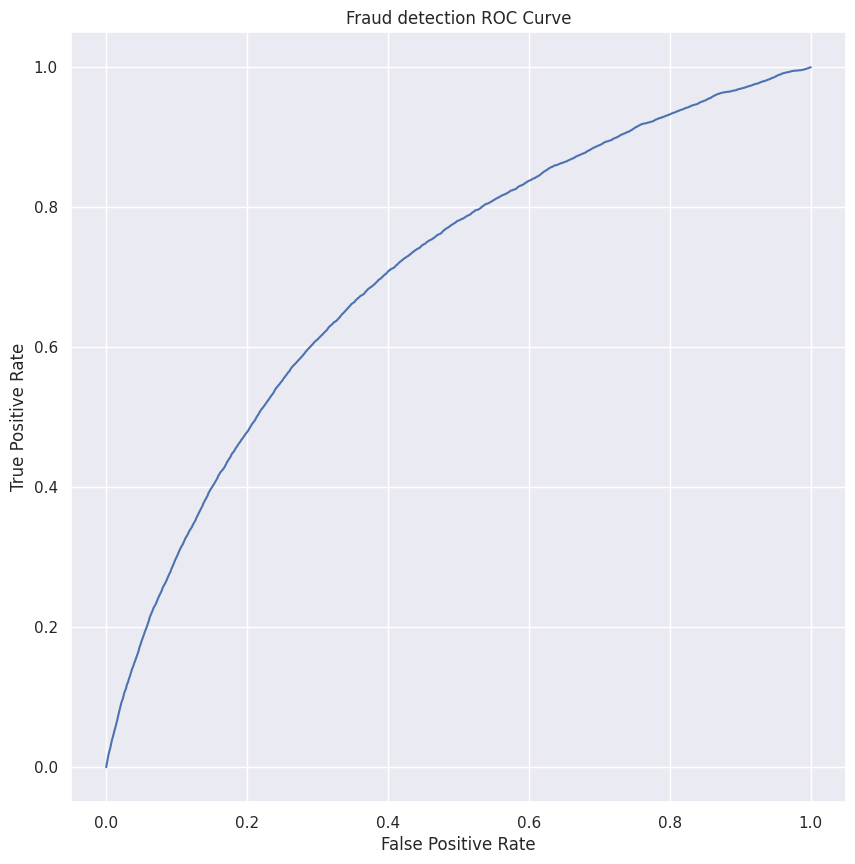

In [ ]:
# your code here
import matplotlib.pyplot as plt

# Create a Pipeline estimator and fit on train DF, predict on test DF
predictions = fitted_cv2.transform(testData)

# Returns as a list (false positive rate, true positive rate)
preds = predictions.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
points = CurveMetrics(preds).get_curve('roc')

plt.figure()
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.title('Fraud detection ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(x_val, y_val)

In [ ]:
avg_auc = fitted_cv2.avgMetrics

In [ ]:
best_model_auc = max(avg_auc)
best_model_auc

0.7043535352092088

In [ ]:
paramGrid = ParamGridBuilder() \
    .addGrid(rf.maxDepth, [5, 10, 15]) \
    .addGrid(rf.numTrees, [20, 50, 100]) \
    .build()

In [ ]:
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")
pipe1 = Pipeline(stages=[va,dt])

In [ ]:
evaluator = BinaryClassificationEvaluator().setLabelCol("label")
cv2 = CrossValidator(estimator=pipe1, estimatorParamMaps=paramGrid, evaluator=evaluator)
fitted_cv3 = cv2.fit(trainingData)

In [ ]:
bce.evaluate(fitted_cv3.transform(testData), {bce.metricName: "areaUnderROC"})

0.6803555131315644

In [ ]:
bce.evaluate(fitted_cv3.transform(testData), {bce.metricName: "areaUnderPR"})

0.6719329765456108

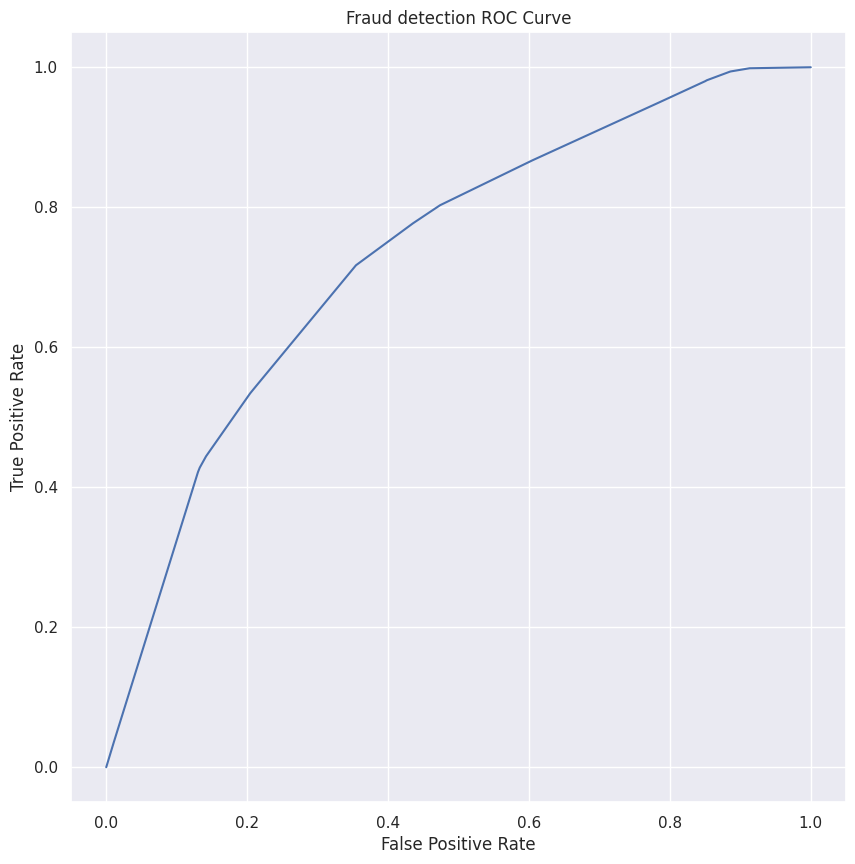

In [ ]:
# your code here
import matplotlib.pyplot as plt

# Create a Pipeline estimator and fit on train DF, predict on test DF
predictions = fitted_cv3.transform(testData)

# Returns as a list (false positive rate, true positive rate)
preds = predictions.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
points = CurveMetrics(preds).get_curve('roc')

plt.figure()
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.title('Fraud detection ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(x_val, y_val)

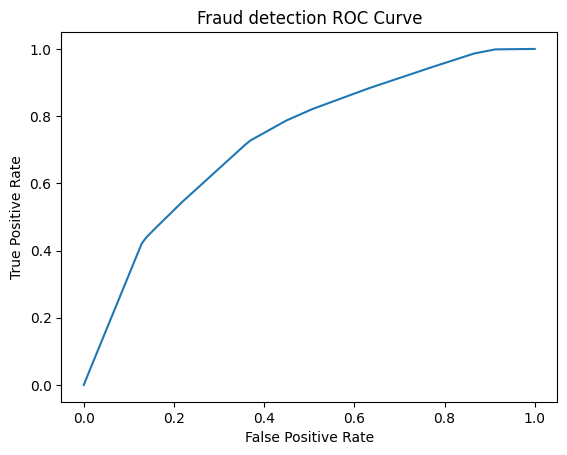

In [ ]:
# your code here
import matplotlib.pyplot as plt

# Create a Pipeline estimator and fit on train DF, predict on test DF
predictions = fitted_cv3.transform(trainingData)

# Returns as a list (false positive rate, true positive rate)
preds = predictions.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
points = CurveMetrics(preds).get_curve('roc')

plt.figure()
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.title('Fraud detection ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(x_val, y_val)

In [ ]:
rf = RandomForestClassifier(featuresCol='features', labelCol='label')
pipe3 = Pipeline(stages=[va,rf])

In [ ]:
evaluator = BinaryClassificationEvaluator().setLabelCol("label")
cv2 = CrossValidator(estimator=pipe3, estimatorParamMaps=paramGrid, evaluator=evaluator)
fitted_cv4 = cv2.fit(trainingData)

In [ ]:
bce.evaluate(fitted_cv4.transform(testData), {bce.metricName: "areaUnderROC"})

0.7456264955641793

In [ ]:
bce.evaluate(fitted_cv4.transform(testData), {bce.metricName: "areaUnderPR"})

0.7257881720145769

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


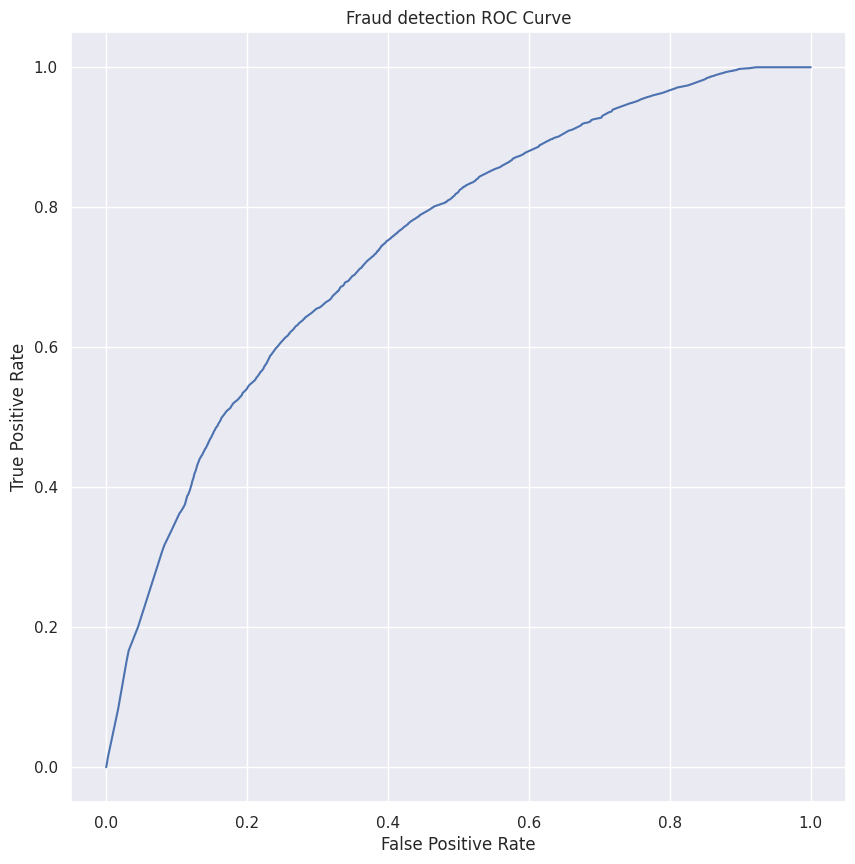

In [ ]:
# your code here
import matplotlib.pyplot as plt

# Create a Pipeline estimator and fit on train DF, predict on test DF
predictions = fitted_cv4.transform(testData)

# Returns as a list (false positive rate, true positive rate)
preds = predictions.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
points = CurveMetrics(preds).get_curve('roc')

plt.figure()
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.title('Fraud detection ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(x_val, y_val)

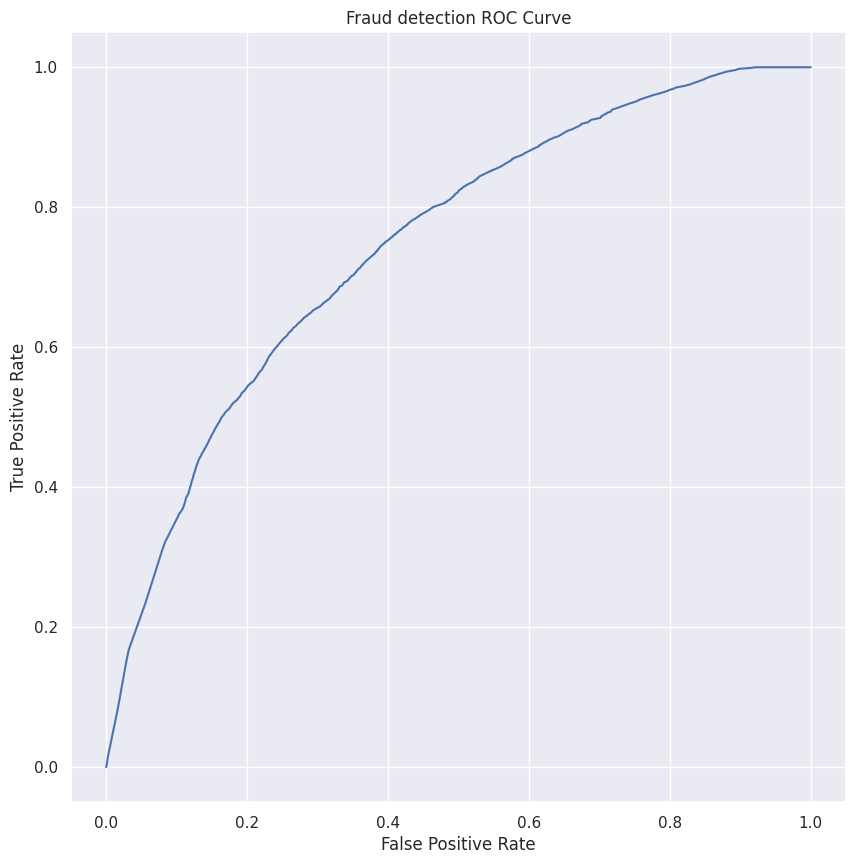

In [ ]:
# your code here
import matplotlib.pyplot as plt

# Create a Pipeline estimator and fit on train DF, predict on test DF
predictions = fitted_cv4.transform(trainingData)

# Returns as a list (false positive rate, true positive rate)
preds = predictions.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
points = CurveMetrics(preds).get_curve('roc')

plt.figure()
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.title('Fraud detection ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(x_val, y_val)

In [ ]:
best_model = fitted_cv4.bestModel
best_model_params = best_model.stages[-1].extractParamMap()
param = []
values = []
for p in best_model_params:
  param.append(p.name)
  values.append(best_model_params[p])

In [ ]:
param_df = pd.DataFrame({'Name': param, 'Values': values})
#param_df = param_df.append({'Name': 'auc_score', 'Values': score}, ignore_index=True)
param_df

,Name,Values
0,bootstrap,True
1,cacheNodeIds,False
2,checkpointInterval,10
3,featureSubsetStrategy,auto
4,featuresCol,features
5,impurity,gini
6,labelCol,label
7,leafCol,
8,maxBins,32
9,maxDepth,5


In [ ]:
len(best_model.stages[-1].featureImportances.values)

10

In [ ]:
feat_values = best_model.stages[-1].featureImportances.values
feat_imp_df = pd.DataFrame({'feature':indexed_df_select.columns[:10],'importance':feat_values}).sort_values('importance',ascending=False)
feat_imp_df

,feature,importance
1,transactionAmount,0.384146
8,merchantCategoryCode_encode,0.306703
9,posEntryMode_encode,0.198061
7,cardPresent_int,0.095132
0,creditLimit,0.009043
6,transactionType_encode,0.004028
2,availableMoney,0.001244
4,month,0.000859
3,MatchCVV,0.000608
5,day,0.000177


In [ ]:
bce.evaluate(fitted_cv4.transform(testData), {bce.metricName: "areaUnderPR"})

0.7275627445006558